# Hackaton Triple Ten Retail Challenge

## AED

In [43]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import re
import sklearn.metrics as metrics
from sklearn.cluster import KMeans
from sklearn.preprocessing import RobustScaler, OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_selection import RFE
import sklearn.preprocessing
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import mean_squared_error, make_scorer, accuracy_score, roc_auc_score, roc_curve

In [2]:
# loading dataset
df = pd.read_csv('../data/Online_Retail.csv',encoding='latin1')

In [3]:
# printing first rows of our dataset
df.head()

,INVOICE_NO,STOCK_CODE,DESCRIPTION,QUANTITY,INVOICE_DATE,UNIT_PRICE,CUSTOMER_ID,REGION
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01/12/2019 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01/12/2019 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01/12/2019 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01/12/2019 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01/12/2019 08:26,3.39,17850.0,United Kingdom


In [4]:
# printing general info of out dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   INVOICE_NO    541909 non-null  object 
 1   STOCK_CODE    541909 non-null  object 
 2   DESCRIPTION   540455 non-null  object 
 3   QUANTITY      541909 non-null  int64  
 4   INVOICE_DATE  541909 non-null  object 
 5   UNIT_PRICE    541909 non-null  float64
 6   CUSTOMER_ID   406829 non-null  float64
 7   REGION        541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [5]:
# printing descriptive statistics
df.describe()

,QUANTITY,UNIT_PRICE,CUSTOMER_ID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


### Checking existance of duplicate values

In [6]:
# checking for duplicate values existance
df.duplicated().sum()

np.int64(5268)

In [7]:
# Eliminating duplicates
df.drop_duplicates(inplace=True)

### Checking existence of missing values 

In [8]:
# Calculaing amount of missing values per column
df.isna().sum()

INVOICE_NO           0
STOCK_CODE           0
DESCRIPTION       1454
QUANTITY             0
INVOICE_DATE         0
UNIT_PRICE           0
CUSTOMER_ID     135037
REGION               0
dtype: int64

## Conclusion of data exploration

In the dataset were found the following problems:

- Existence of duplicate values, 5268 rows.
- Column names are all capitalized.
- Data type of `invoice_date` column must be datetime. 
- Existence of missing values, 135080 rows in `customer_id` column and 1454 in `description` column.
- Existence columns with a data type that is not consistent with the type of data stored in the column. We have negative values in columns like `quantity` and `unit_price`

## Cleaning and preparation
### Lowering column names

In [9]:
# Lowering coloumn names
df.columns = df.columns.str.lower() 

### Updating `invoice_date` data type to datetime

In [10]:
# updating dtype to datetime
df['invoice_date'] = pd.to_datetime(df['invoice_date'],format='mixed')

### Missing Values

We'll look for ways to input some data to fill our missing values in `customer_id` and `description` columns. 

#### `description`

In [11]:
# printing rows with mising values in description column
df[df['description'].isna()]

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,region
622,536414,22139,NaN,56,2019-01-12 11:52:00,0.0,NaN,United Kingdom
1970,536545,21134,NaN,1,2019-01-12 14:32:00,0.0,NaN,United Kingdom
1971,536546,22145,NaN,1,2019-01-12 14:33:00,0.0,NaN,United Kingdom
1972,536547,37509,NaN,1,2019-01-12 14:33:00,0.0,NaN,United Kingdom
1987,536549,85226A,NaN,1,2019-01-12 14:34:00,0.0,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
535322,581199,84581,NaN,-2,2020-07-12 18:26:00,0.0,NaN,United Kingdom
535326,581203,23406,NaN,15,2020-07-12 18:31:00,0.0,NaN,United Kingdom
535332,581209,21620,NaN,6,2020-07-12 18:35:00,0.0,NaN,United Kingdom
536981,581234,72817,NaN,27,2020-08-12 10:33:00,0.0,NaN,United Kingdom


In [12]:
# checking if we can replace description using the stock code of the items 
df[df['stock_code'] == '21134']

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,region
1970,536545,21134,NaN,1,2019-01-12 14:32:00,0.0,NaN,United Kingdom


In [13]:
# checking if we can replace description using the stock code of the items 
df[df['stock_code'] == '22145']

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,region
1971,536546,22145,NaN,1,2019-01-12 14:33:00,0.0,NaN,United Kingdom
19025,537827,22145,CHRISTMAS CRAFT HEART STOCKING,30,2019-08-12 14:43:00,2.1,15332.0,Lithuania
20392,538041,22145,NaN,30,2019-09-12 13:09:00,0.0,NaN,United Kingdom


We see that we in some cases we can use the stock code to look for the description and replace the missing value on our `description` column. We'll follow this approach and then decide what to do with the remaining missing values in this column

In [14]:
# Create a mapping of 'stock_code' to 'description'
stock_code_to_description = df.dropna(subset=['description']).set_index('stock_code')['description'].to_dict()
# Fill missing 'description' values using the 'stock_code' mapping
df['description'] = df.apply(
    lambda row: stock_code_to_description.get(row['stock_code'], row['description']) if pd.isnull(row['description']) else row['description'],
    axis=1
)

In [15]:
# we check for missing values on the column again
df['description'].isna().sum()

np.int64(112)

We reduce the missing values of our column from 1454 to 112. We can eliminate the remaing columns with missgin values, but first we'll replace values on the `customer_id` column following a similar approach and then analize the possibily of eliminating all the remaining missing values

#### `customer_id`

We'll analize the possibily to replace missing values by inputing data using the `invoice_no` column as a reference

In [16]:
df[df['customer_id'].isna()]

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,region
622,536414,22139,RETROSPOT TEA SET CERAMIC 11 PC,56,2019-01-12 11:52:00,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,2019-01-12 14:32:00,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,2019-01-12 14:32:00,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,2019-01-12 14:32:00,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,2019-01-12 14:32:00,1.66,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
541536,581498,85099B,JUMBO BAG RED RETROSPOT,5,2020-09-12 10:26:00,4.13,NaN,United Kingdom
541537,581498,85099C,JUMBO BAG BAROQUE BLACK WHITE,4,2020-09-12 10:26:00,4.13,NaN,United Kingdom
541538,581498,85150,LADIES & GENTLEMEN METAL SIGN,1,2020-09-12 10:26:00,4.96,NaN,United Kingdom
541539,581498,85174,S/4 CACTI CANDLES,1,2020-09-12 10:26:00,10.79,NaN,United Kingdom


In [17]:
df['customer_id'].isna().sum()

np.int64(135037)

In [18]:
# Create a mapping of 'invoice_no' to 'customer_id'
invice_no_to_customer_id = df.dropna(subset=['customer_id']).set_index('invoice_no')['customer_id'].to_dict()
# Fill missing 'customer_id' values using the 'invoice_no' mapping
df['customer_id'] = df.apply(
    lambda row: invice_no_to_customer_id.get(row['invoice_no'], row['customer_id']) if pd.isnull(row['customer_id']) else row['customer_id'],
    axis=1
)

In [19]:
df['customer_id'].isna().sum()

np.int64(135037)

We can see that this apporach didn't work with this column. We will eliminate the remaing missing values.

In [20]:
df.dropna(inplace=True)
# We check for missing values
df.isna().sum()

invoice_no      0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
customer_id     0
region          0
dtype: int64

We have cleaned our dataset from missing values

### Outliers

In [21]:
df.describe()

,quantity,invoice_date,unit_price,customer_id
count,401604.000000,401604,401604.000000,401604.000000
mean,12.183273,2020-06-21 01:01:42.294798080,3.474064,15281.160818
min,-80995.000000,2019-01-12 08:26:00,0.000000,12346.000000
25%,2.000000,2020-03-30 11:39:00,1.250000,13939.000000
50%,5.000000,2020-07-08 13:08:00,1.950000,15145.000000
75%,12.000000,2020-10-08 16:39:00,3.750000,16784.000000
max,80995.000000,2020-12-10 17:19:00,38970.000000,18287.000000
std,250.283037,NaN,69.764035,1714.006089


In [46]:
# Definimos un fórmula para analizar outliers 

def outliers(df,col,ylabel=None):
    sns.set(style="whitegrid")
    plt.figure(figsize=(8, 5))
    sns.boxplot(x=df[col], color='skyblue')
    plt.title('Boxplot of ' + col)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()

    min = df[col].min()
    values_0 = len(df[df[col] <= 0])
    percentage_values_0 = '{:.2%}'.format(len(df[df[col] <= 0])/len(df))

    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    up_limit = Q3 + IQR
    low_limit = Q1 - IQR

    values_up_limit = len(df[df[col] >= up_limit])
    values_low_limit = len(df[df[col] <= low_limit])

    percentage_up_limit = '{:.2%}'.format(len(df[df[col] >= up_limit])/len(df))
    percentage_low_limit = '{:.2%}'.format(len(df[df[col] <= low_limit])/len(df))

    print(df[col].describe())
    print()
    print(f'El IQR de {col} es {IQR}')
    print()
    
    print(f'EL limite inferior de nuestro boxplot es {low_limit}')
    print()
    print(f'La cantidad de valores iguales o menores a {low_limit} es {values_low_limit}')
    print()
    print(f'El porcentaje de valores iguales o menores a {low_limit} es {percentage_low_limit}')

    print()
    print(f'EL limite superior es de nuestro boxplot es {up_limit}')
    print()
    print(f'La cantidad de volores iguales o superiores a {up_limit} es {values_up_limit}')
    print()
    print(f'Elporcentaje de valores iguales o superiores a {up_limit} es {percentage_up_limit}')

#### `quantity`

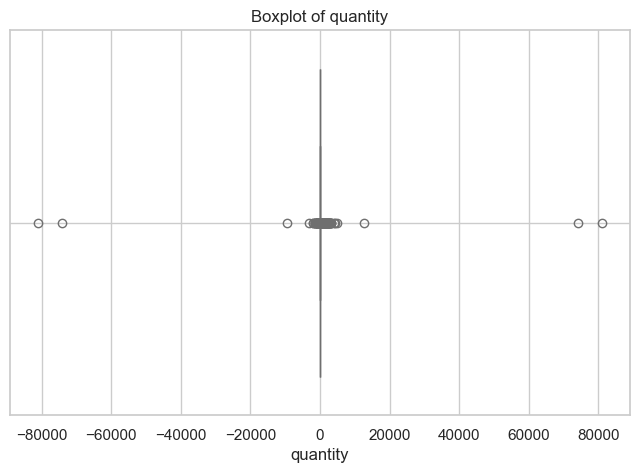

count    401604.000000
mean         12.183273
std         250.283037
min      -80995.000000
25%           2.000000
50%           5.000000
75%          12.000000
max       80995.000000
Name: quantity, dtype: float64

El IQR de quantity es 10.0

EL limite inferior de nuestro boxplot es -8.0

La cantidad de valores iguales o menores a -8.0 es 1953

El porcentaje de valores iguales o menores a -8.0 es 0.49%

EL limite superior es de nuestro boxplot es 22.0

La cantidad de volores iguales o superiores a 22.0 es 54468

Elporcentaje de valores iguales o superiores a 22.0 es 13.56%


In [47]:
outliers(df,'quantity')

In [24]:
q=df.groupby(['customer_id','invoice_no'], as_index=False)[['quantity','unit_price']].sum()
q[q['quantity'] < 0 ]

,customer_id,invoice_no,quantity,unit_price
1,12346.0,C541433,-74215,1.04
23,12352.0,C545329,-2,463.80
24,12352.0,C545330,-1,376.50
25,12352.0,C547388,-63,16.69
39,12359.0,C549955,-4,17.90
...,...,...,...,...
22159,18274.0,C577832,-88,40.39
22161,18276.0,C577386,-1,6.25
22162,18276.0,C577390,-1,6.25
22164,18277.0,C542086,-1,12.75


We see that the negative numbers we have on our `quantity` column is due to orders that have been canceled. We won't make any changes to this column

#### `unit_price`

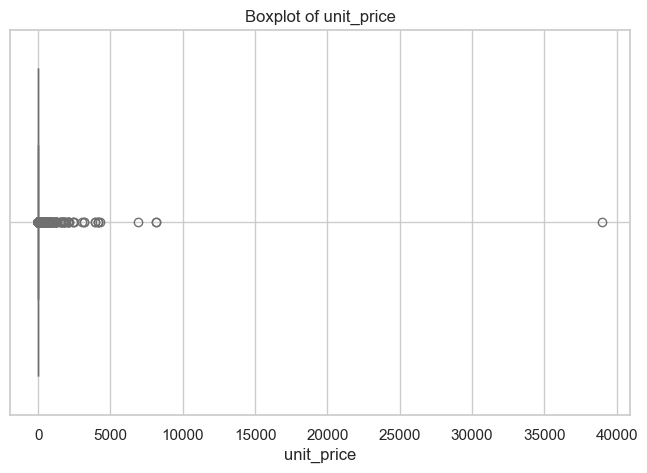

count    401604.000000
mean          3.479491
std          69.776340
min           0.001000
25%           1.250000
50%           1.950000
75%           3.750000
max       38970.000000
Name: unit_price, dtype: float64

El IQR de unit_price es 2.5

EL limite inferior de nuestro boxplot es -1.25

La cantidad de valores iguales o menores a -1.25 es 0

El porcentaje de valores iguales o menores a -1.25 es 0.00%

EL limite superior es de nuestro boxplot es 6.25

La cantidad de volores iguales o superiores a 6.25 es 42859

Elporcentaje de valores iguales o superiores a 6.25 es 10.67%


In [48]:
outliers(df,'unit_price')

We see we have prices of 0.00. We'll replca that inputing prices using the `stock_code` number

In [26]:
# We check for the amoung of numbers with a value of 0
len(df[df['unit_price'] == 0])

40

In [27]:
unit_price=df.groupby('stock_code', as_index=False)['unit_price'].unique()
unit_price

,stock_code,unit_price
0,10002,[0.85]
1,10080,"[0.85, 0.39]"
2,10120,[0.21]
3,10123C,[0.65]
4,10124A,[0.42]
...,...,...
3679,D,"[27.5, 29.29, 281.0, 267.12, 5.76, 42.5, 26.93..."
3680,DOT,"[11.17, 16.46, 13.16, 85.58, 878.55, 688.08, 4..."
3681,M,"[1.25, 18.95, 0.85, 0.42, 0.65, 1.0, 0.19, 35...."
3682,PADS,"[0.001, 0.0]"


We can see we have more than on price per item. We'll use the mean of these prices to replace the 0 values on this column

In [28]:
# We create the new df
mean_prices = df[df['unit_price'] > 0].groupby('stock_code')['unit_price'].mean()

# Function to replace zero unit prices with the mean unit price for the stock_code
def replace_zero_unit_price(row):
    if row['unit_price'] == 0:
        return mean_prices.get(row['stock_code'], row['unit_price'])
    else:
        return row['unit_price']

# Apply the function to the DataFrame
df['unit_price'] = df.apply(replace_zero_unit_price, axis=1)

len(df[df['unit_price'] < 0])

0

We successfully replaced all 0 valus on this column. We won't make other changes.

## Creation of new columns

In [29]:
df['total_purchase'] = df['quantity'] * df['unit_price']
df['year'] = df['invoice_date'].dt.year
df['month'] = df['invoice_date'].dt.month
df['day'] = df['invoice_date'].dt.day
df['hour'] = df['invoice_date'].dt.hour
df = df.sort_values(by='invoice_date')
df['frequency'] = df.groupby('customer_id')['invoice_no'].transform('nunique')
df['recency'] = (df['invoice_date'].max() - df.groupby('customer_id')['invoice_date'].transform('max')).dt.days
df['monetary_value'] = df.groupby('customer_id')['total_purchase'].transform('sum')

## Graphs

### Top 10 Selling Regions

In [30]:
# Contar el número de ventas por región
region_counts = df['region'].value_counts().head(10)
region_counts

region
United Kingdom    356728
Germany             9480
France              8475
EIRE                7475
Spain               2528
Netherlands         2371
Belgium             2069
Switzerland         1877
Portugal            1471
Australia           1258
Name: count, dtype: int64

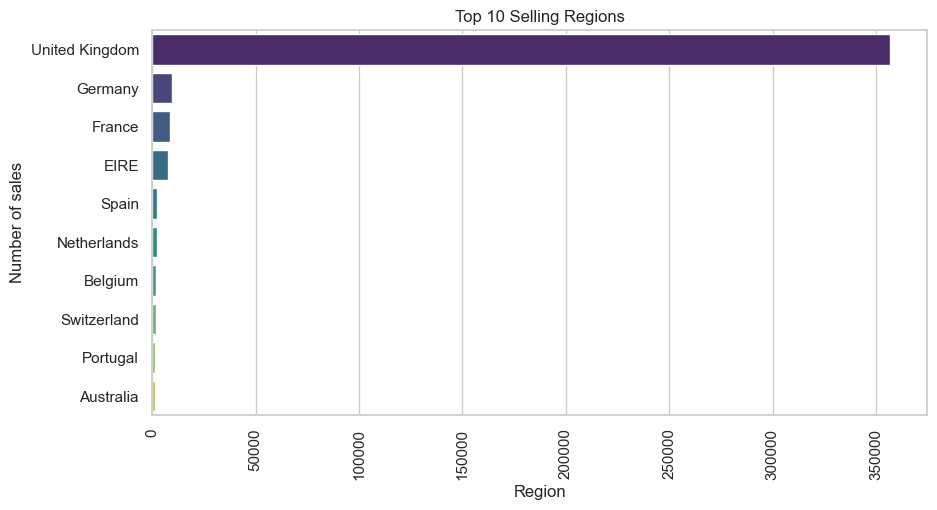

In [31]:
# Crear un gráfico de barras para las ventas por región
plt.figure(figsize=(10, 5))
sns.barplot(x=region_counts.values, y=region_counts.index, palette='viridis',hue=region_counts.index)
plt.title('Top 10 Selling Regions')
plt.xlabel('Region')
plt.ylabel('Number of sales')
plt.xticks(rotation=90)
plt.show()

### Top 10 selling Regions in dolars

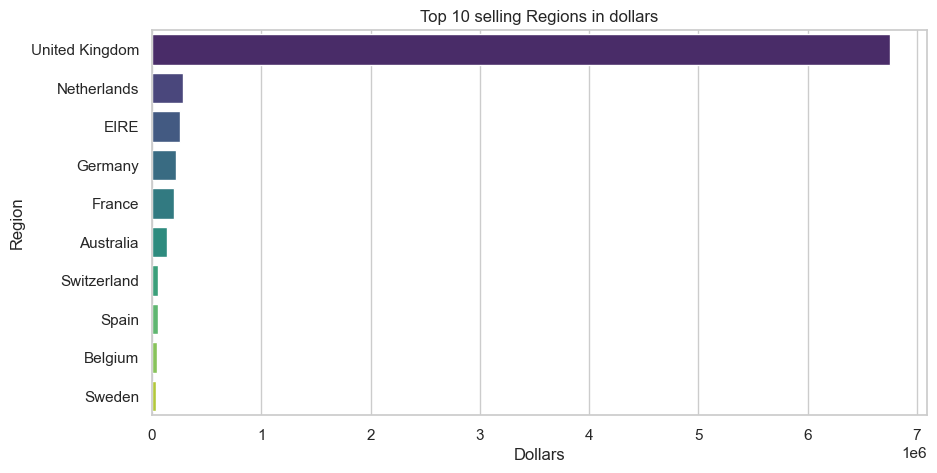

In [32]:
# Calcular las ventas totales por país
ventas_por_pais = df.groupby('region')['total_purchase'].sum().reset_index()

# Ordenar los países por cantidad vendida en orden descendente y seleccionar los primeros 10
top_10_paises = ventas_por_pais.sort_values(by='total_purchase', ascending=False).head(10)

plt.figure(figsize=(10, 5))
sns.barplot(x='total_purchase', y='region', data=top_10_paises, palette='viridis',hue='region')
plt.title('Top 10 selling Regions in dollars')
plt.xlabel('Dollars')
plt.ylabel('Region')
plt.show()

### Top 10 selling products

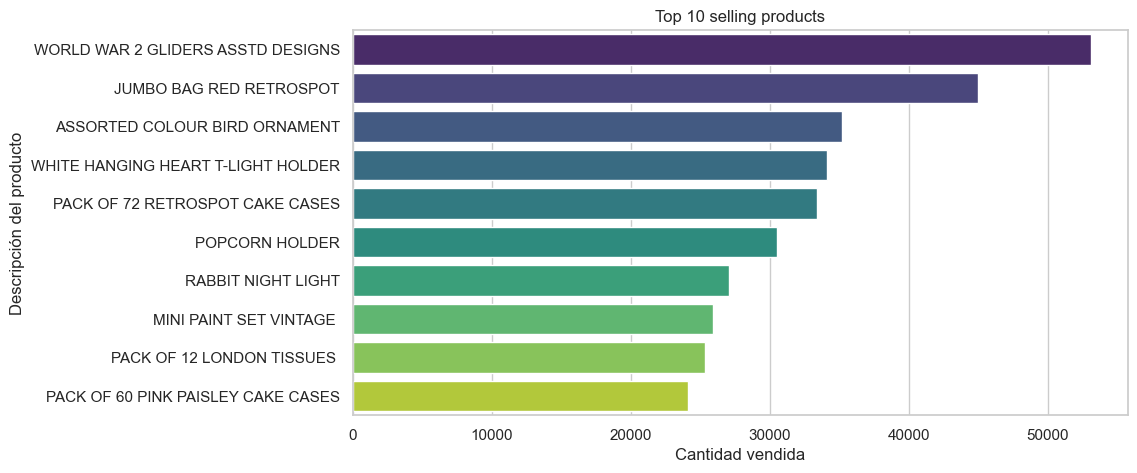

In [33]:
# Top 10 productos más vendidos
productos_mas_vendidos = df.groupby('description')['quantity'].sum().reset_index()
productos_mas_vendidos = productos_mas_vendidos.sort_values(by='quantity', ascending=False).head(10)

plt.figure(figsize=(10, 5))
sns.barplot(x='quantity', y='description', data=productos_mas_vendidos, palette='viridis',hue='description')
plt.title('Top 10 selling products')
plt.xlabel('Cantidad vendida')
plt.ylabel('Descripción del producto')
plt.show()

### Top 50 selling producsts per Region

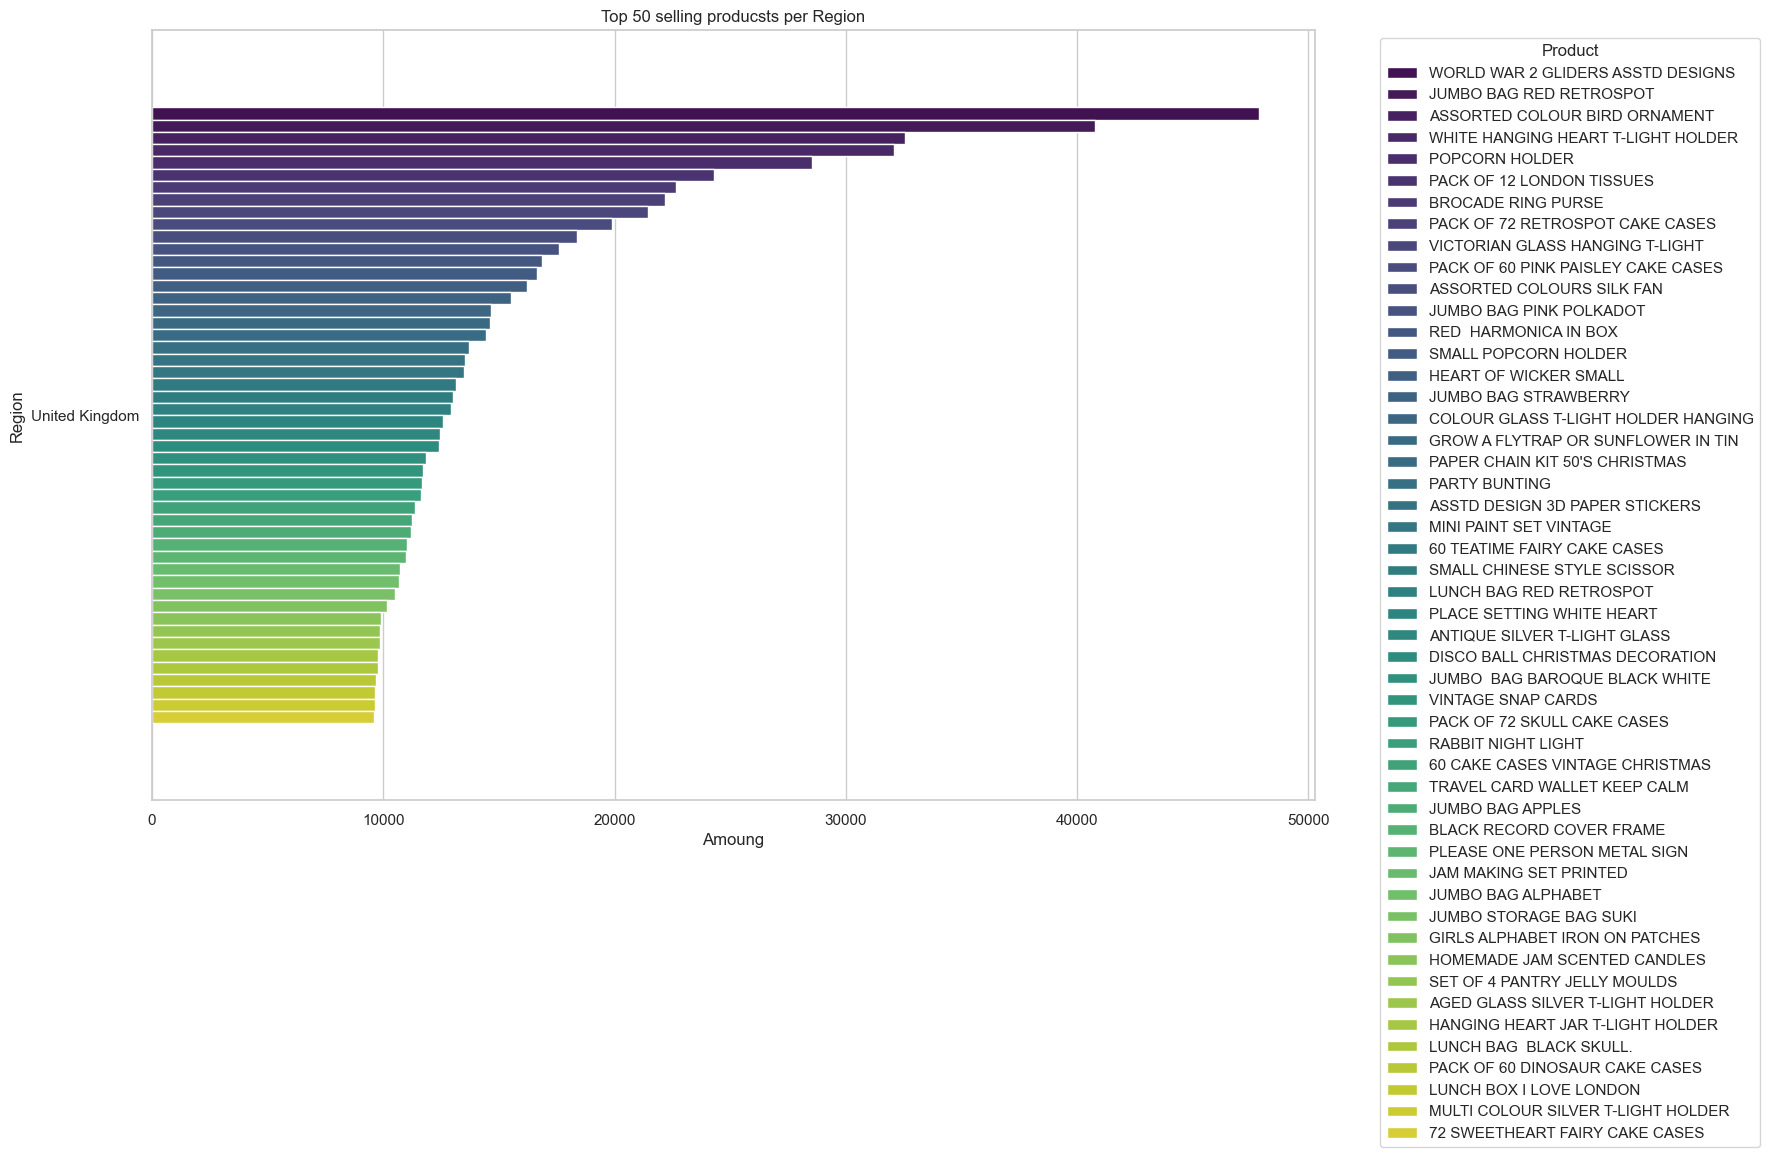

In [34]:
# Distribución de ventas por región y tipo de producto
ventas_por_region_producto = df.groupby(['region', 'description'])['quantity'].sum().reset_index()
ventas_por_region_producto = ventas_por_region_producto.sort_values(by='quantity', ascending=False)

plt.figure(figsize=(15, 10))
sns.barplot(x='quantity', y='region', hue='description', data=ventas_por_region_producto.head(50), palette='viridis')
plt.title('Top 50 selling producsts per Region')
plt.xlabel('Amoung')
plt.ylabel('Region')
plt.legend(title='Product', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

### Time line Sales in Dollars

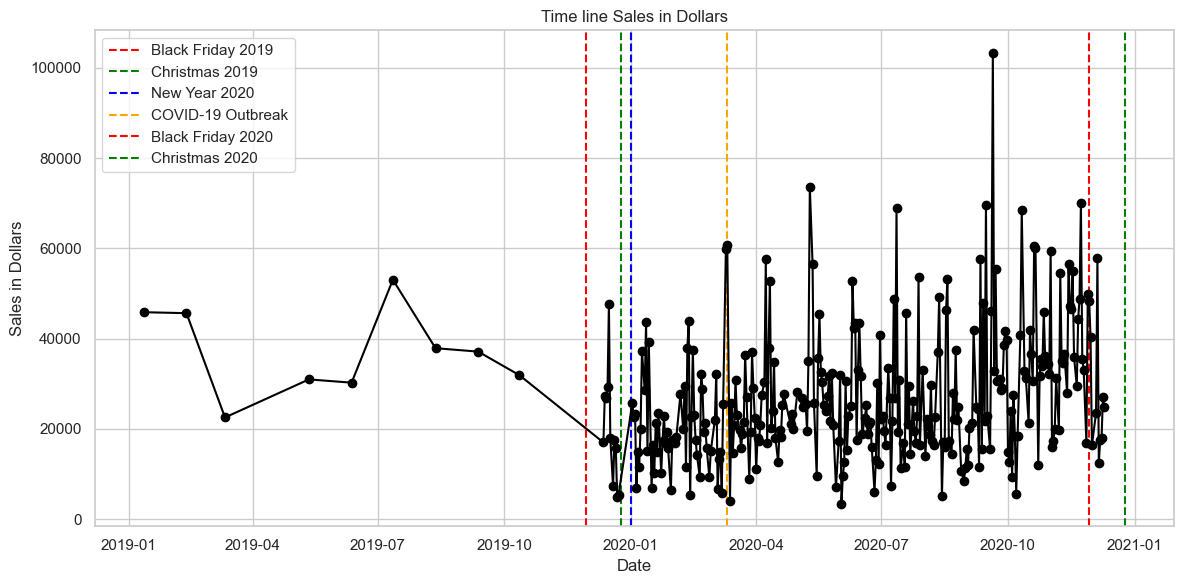

In [35]:
# Agrupar por fecha y sumar las cantidades vendidas
sales_timeline = df.groupby(df['invoice_date'].dt.date)['total_purchase'].sum().reset_index()

# Definir algunas fechas clave con colores
important_dates = {
    'Black Friday 2019': {'date': pd.Timestamp('2019-11-29'), 'color': 'red'},
    'Christmas 2019': {'date': pd.Timestamp('2019-12-25'), 'color': 'green'},
     'New Year 2020': {'date': pd.Timestamp('2020-01-01'), 'color': 'blue'},
    'COVID-19 Outbreak': {'date': pd.Timestamp('2020-03-11'), 'color': 'orange'},
    'Black Friday 2020': {'date': pd.Timestamp('2020-11-29'), 'color': 'red'},
    'Christmas 2020': {'date': pd.Timestamp('2020-12-25'), 'color': 'green'}
}

# Crear el gráfico de línea
plt.figure(figsize=(12, 6))
for date_name, info in important_dates.items():
    date_value = info['date']
    color = info['color']
    plt.axvline(x=date_value, color=color, linestyle='--', label=date_name)

plt.plot(sales_timeline['invoice_date'], sales_timeline['total_purchase'], marker='o', linestyle='-', color='black')

plt.title('Time line Sales in Dollars')
plt.xlabel('Date')
plt.ylabel('Sales in Dollars')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Client Segmentation

In [36]:
cluster_features = ['frequency','recency','monetary_value']
clustering_df = df[cluster_features]

#num_features = list(clustering_df.drop('region',axis=1).columns)
num_features = cluster_features
num_transformer = RobustScaler()

#cat_features = ['region']
#cat_tranformer = OneHotEncoder()

pipeline = Pipeline(
    steps=[('preprocessor',ColumnTransformer(
        transformers= [
            ('num',num_transformer, num_features),
            #('cat',cat_tranformer,cat_features)
        ]
    ))])

transformed_data = pipeline.fit_transform(clustering_df)
if hasattr(transformed_data, "toarray"):
    transformed_data = transformed_data.toarray()
all_features = num_features #+ pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(cat_features).tolist()
clustering_df = pd.DataFrame(transformed_data, columns= all_features)
clustering_df.head()

,frequency,recency,monetary_value
0,1.8,1.088889,0.528013
1,1.8,1.088889,0.528013
2,1.8,1.088889,0.528013
3,1.8,1.088889,0.528013
4,1.8,1.088889,0.528013


## Segmentacion

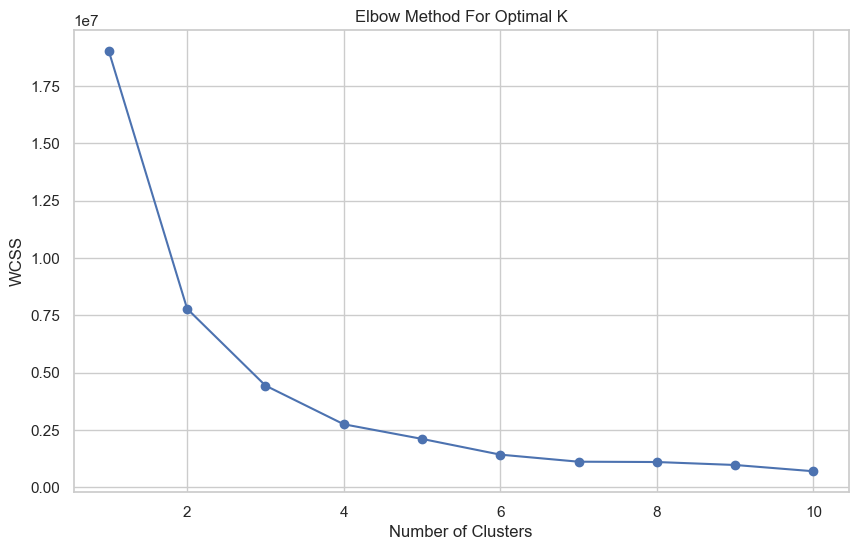

In [37]:
wcss= []
k_range = range(1,11)
for k in k_range:
    Kmeans = KMeans(n_clusters=k,random_state=42)
    Kmeans.fit(clustering_df)
    wcss.append(Kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, wcss, marker='o')
plt.title('Elbow Method For Optimal K')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()


In [38]:
cluster_model = KMeans(n_clusters = 3,random_state=42)
cluster_model.fit(clustering_df)
df['cluster'] = cluster_model.labels_
df.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,region,total_purchase,year,month,day,hour,frequency,recency,monetary_value,cluster
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2019-01-12 08:26:00,2.55,17850.0,United Kingdom,15.30,2019,1,12,8,35,69,5303.48,0
1,536365,71053,WHITE METAL LANTERN,6,2019-01-12 08:26:00,3.39,17850.0,United Kingdom,20.34,2019,1,12,8,35,69,5303.48,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2019-01-12 08:26:00,2.75,17850.0,United Kingdom,22.00,2019,1,12,8,35,69,5303.48,0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2019-01-12 08:26:00,3.39,17850.0,United Kingdom,20.34,2019,1,12,8,35,69,5303.48,0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2019-01-12 08:26:00,3.39,17850.0,United Kingdom,20.34,2019,1,12,8,35,69,5303.48,0


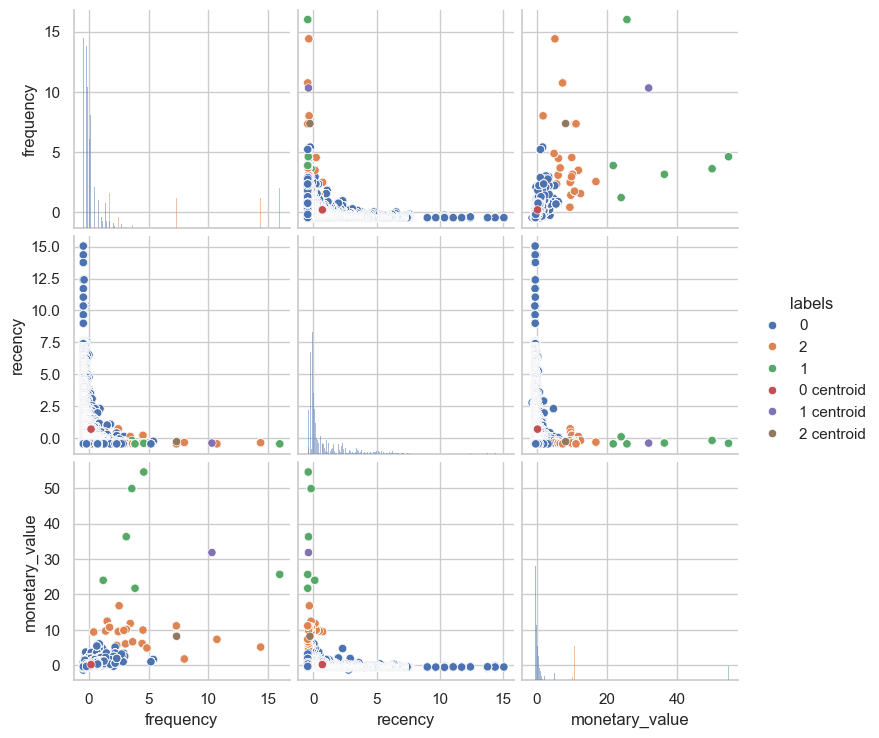

In [39]:
centroids = pd.DataFrame(cluster_model.cluster_centers_, columns=clustering_df.columns)
clustering_df['labels'] = cluster_model.labels_.astype(str)
centroids['labels']= ['0 centroid','1 centroid', '2 centroid']
df_all = pd.concat([clustering_df,centroids],ignore_index=True)
sns.pairplot(df_all,hue='labels',diag_kind='hist')

In [40]:
# Calculating mean values for numerical features for each cluster
cluster_means = df.groupby('cluster')[cluster_features].mean()
cluster_means

,frequency,recency,monetary_value
cluster,,,
0,10.71465,51.916650,3571.906596
1,162.69395,2.725249,164538.575630
2,118.29790,7.819208,44262.831740


In [41]:
# preparing data for radar chart
labels = np.array(cluster_features)

# creating a dataframe for the radar chart
radar_df = cluster_means[cluster_features].reset_index()

# normalizing the data
radar_df_normalized = radar_df.copy()
for feature in cluster_features:
    radar_df_normalized[feature] = (radar_df[feature] - radar_df[feature].min()) / (radar_df[feature].max() - radar_df[feature].min())

# assigning names to segments
segment_names = ['Churn Risk Customers', 'High-Value Customers', 'Potential Loyal Customers']

radar_df_normalized

,cluster,frequency,recency,monetary_value
0,0,0.000000,1.000000,0.000000
1,1,1.000000,0.000000,1.000000
2,2,0.707881,0.103554,0.252791


In [44]:
fig = go.Figure()

# loop through each segment to add to the radar chart
for i, segment in enumerate(segment_names):
    fig.add_trace(go.Scatterpolar(
        r=radar_df_normalized.iloc[i][cluster_features].values.tolist() + [radar_df_normalized.iloc[i][cluster_features].values[0]],  # Add the first value at the end to close the radar chart
        theta=labels.tolist() + [labels[0]],  # add the first label at the end to close the radar chart
        fill='toself',
        name=segment,
    ))

# update the layout to finalize the radar chart
fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[-1, 1]
        )),
    showlegend=True,
    title='User Segments Profile'
)

fig.show()

## ML Models
### Feature Selection
#### Funtion to evaluate our models

In [57]:
#Indica las graficas y valores de metricas como exactitud, F1, AUC-ROC, PRC
def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'Curva ROC')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Exactitud'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Exactitud', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

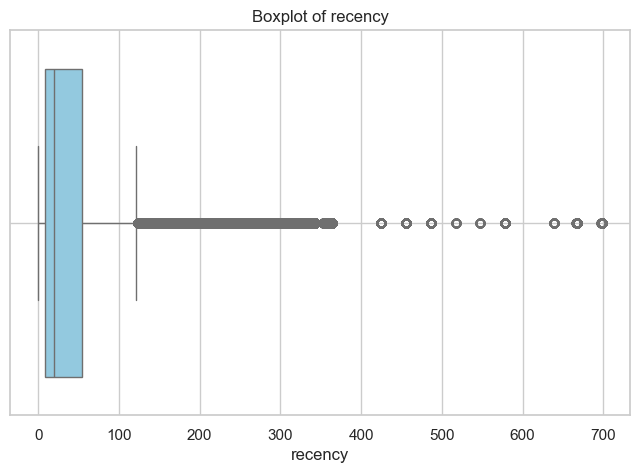

count    401604.000000
mean         47.139775
std          71.544704
min           0.000000
25%           9.000000
50%          20.000000
75%          54.000000
max         698.000000
Name: recency, dtype: float64

El IQR de recency es 45.0

EL limite inferior de nuestro boxplot es -36.0

La cantidad de valores iguales o menores a -36.0 es 0

El porcentaje de valores iguales o menores a -36.0 es 0.00%

EL limite superior es de nuestro boxplot es 99.0

La cantidad de volores iguales o superiores a 99.0 es 54410

Elporcentaje de valores iguales o superiores a 99.0 es 13.55%


In [49]:
outliers(df,'recency')

We'll take the upper limit of our boxplot to create the churh column in our dataset that will become our target for our ML models. 

In [50]:
df['churn'] = np.where(df['recency'] > 99, 1, 0)
df.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,region,total_purchase,year,month,day,hour,frequency,recency,monetary_value,cluster,churn
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2019-01-12 08:26:00,2.55,17850.0,United Kingdom,15.30,2019,1,12,8,35,69,5303.48,0,0
1,536365,71053,WHITE METAL LANTERN,6,2019-01-12 08:26:00,3.39,17850.0,United Kingdom,20.34,2019,1,12,8,35,69,5303.48,0,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2019-01-12 08:26:00,2.75,17850.0,United Kingdom,22.00,2019,1,12,8,35,69,5303.48,0,0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2019-01-12 08:26:00,3.39,17850.0,United Kingdom,20.34,2019,1,12,8,35,69,5303.48,0,0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2019-01-12 08:26:00,3.39,17850.0,United Kingdom,20.34,2019,1,12,8,35,69,5303.48,0,0


In [51]:
#Features and target
features = df[cluster_features]
target = df['churn']

features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.2, random_state=42)

In [52]:
train_data = pd.concat([features_train, target_train], axis=1)

# Matriz de correlación
correlation_matrix = train_data.corr(method='spearman')
#ver corr parametro

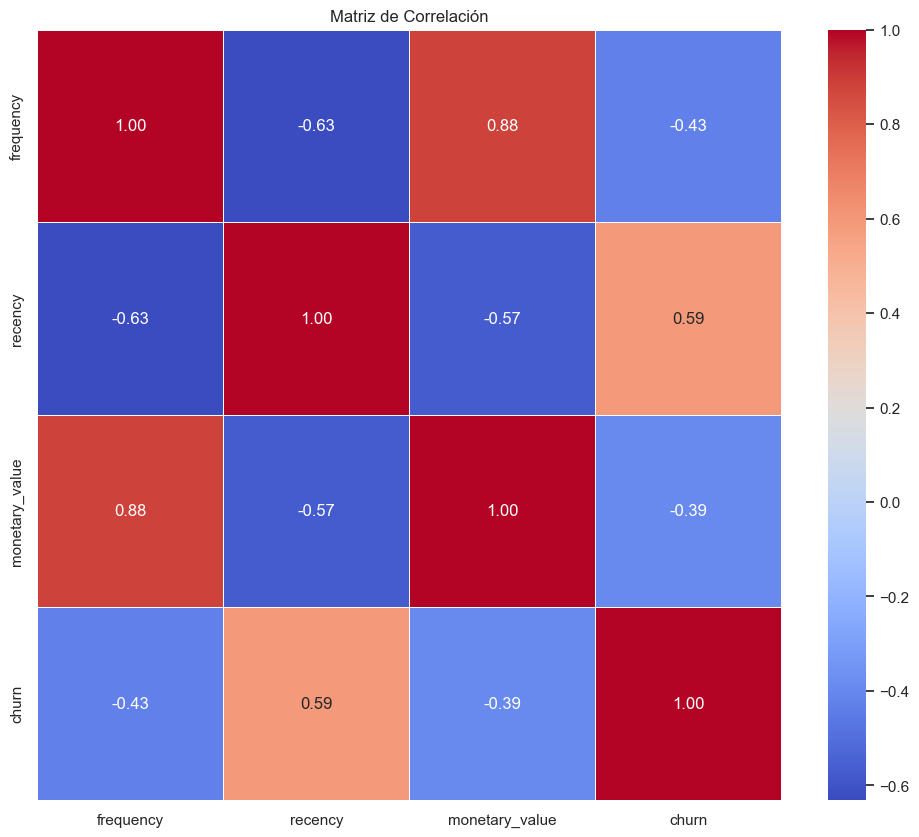

In [53]:
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriz de Correlación')
plt.show()

### Modelo Dummy

           train  test
Exactitud   0.86  0.87
F1          0.00  0.00
APS         0.14  0.13
ROC AUC     0.50  0.50


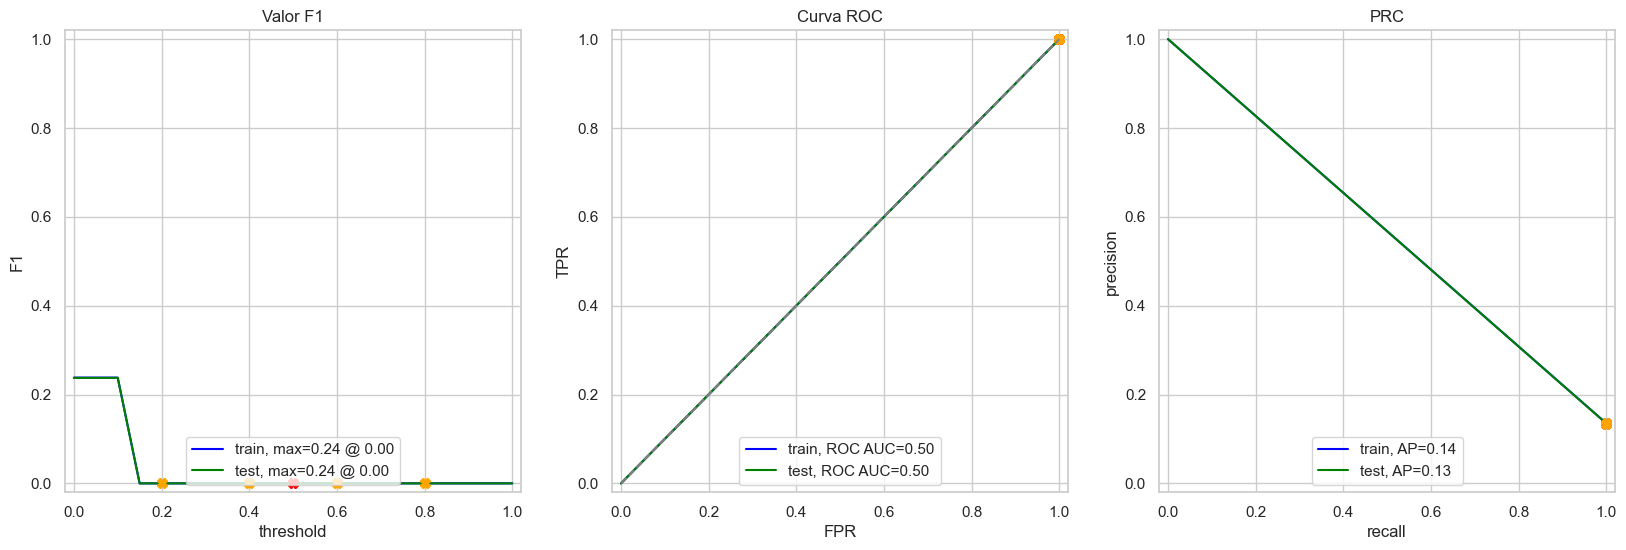

In [58]:
dummy_cl = DummyClassifier(random_state=12345)
dummy_cl.fit(features_train, target_train)
evaluate_model(dummy_cl, features_train, target_train, features_valid, target_valid)

### Regresión Logística

           train  test
Exactitud   0.95  0.95
F1          0.83  0.84
APS         0.92  0.93
ROC AUC     0.97  0.97


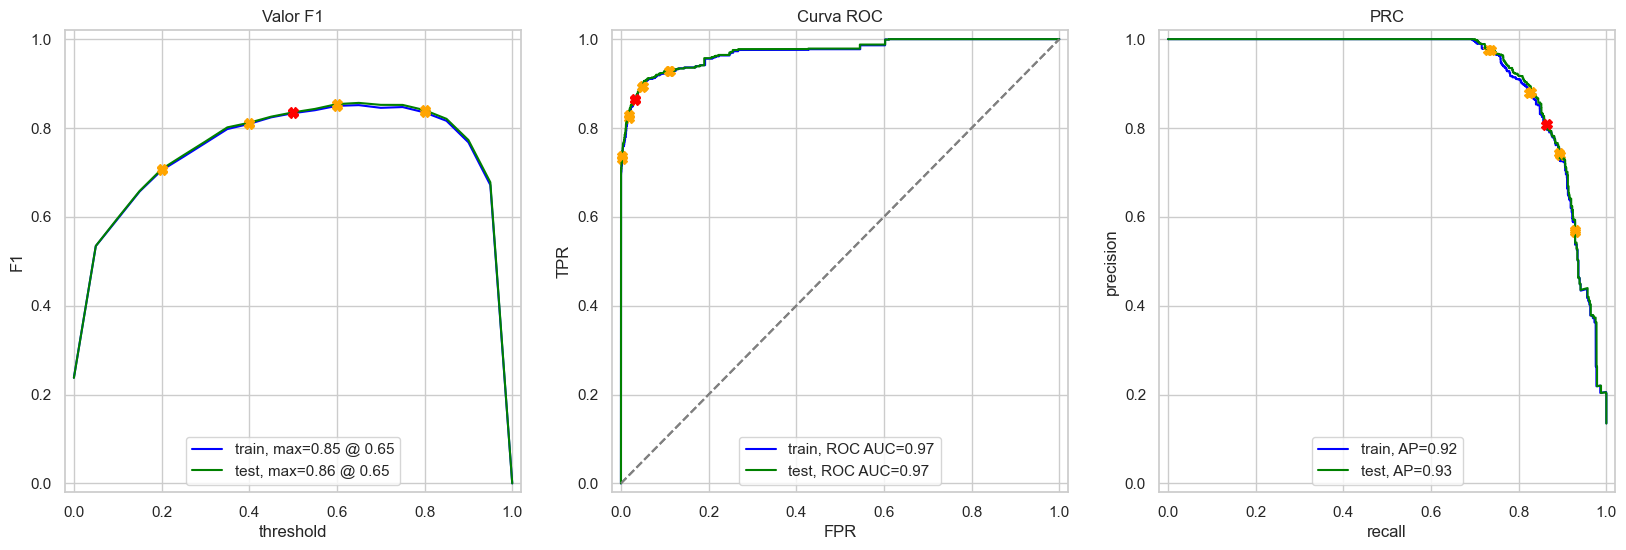

In [59]:
model_lr=LogisticRegression(solver='liblinear', random_state=12345)
model_lr.fit(features_train, target_train)
evaluate_model(model_lr, features_train, target_train, features_valid, target_valid)

In [81]:
score_valid=0.95
auc_roc_lr=0.97

### Árbol de decisión

In [61]:
model_tree = DecisionTreeClassifier()
param_grid = {
    'criterion':['gini', 'entropy'],
    'max_depth': [10, 20, 50, 100],
    'class_weight':[None, 'balanced'],
    'random_state':[12345]
}
grid_tree = GridSearchCV(estimator=model_tree, param_grid=param_grid, scoring='roc_auc', cv=5, n_jobs=-1)
grid_tree.fit(features_train, target_train)
best_param_tree=grid_tree.best_params_


In [62]:
print(best_param_tree)
print(grid_tree.best_score_)

{'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'random_state': 12345}
1.0


CPU times: total: 0 ns
Wall time: 815 μs
           train  test
Exactitud    1.0   1.0
F1           1.0   1.0
APS          1.0   1.0
ROC AUC      1.0   1.0


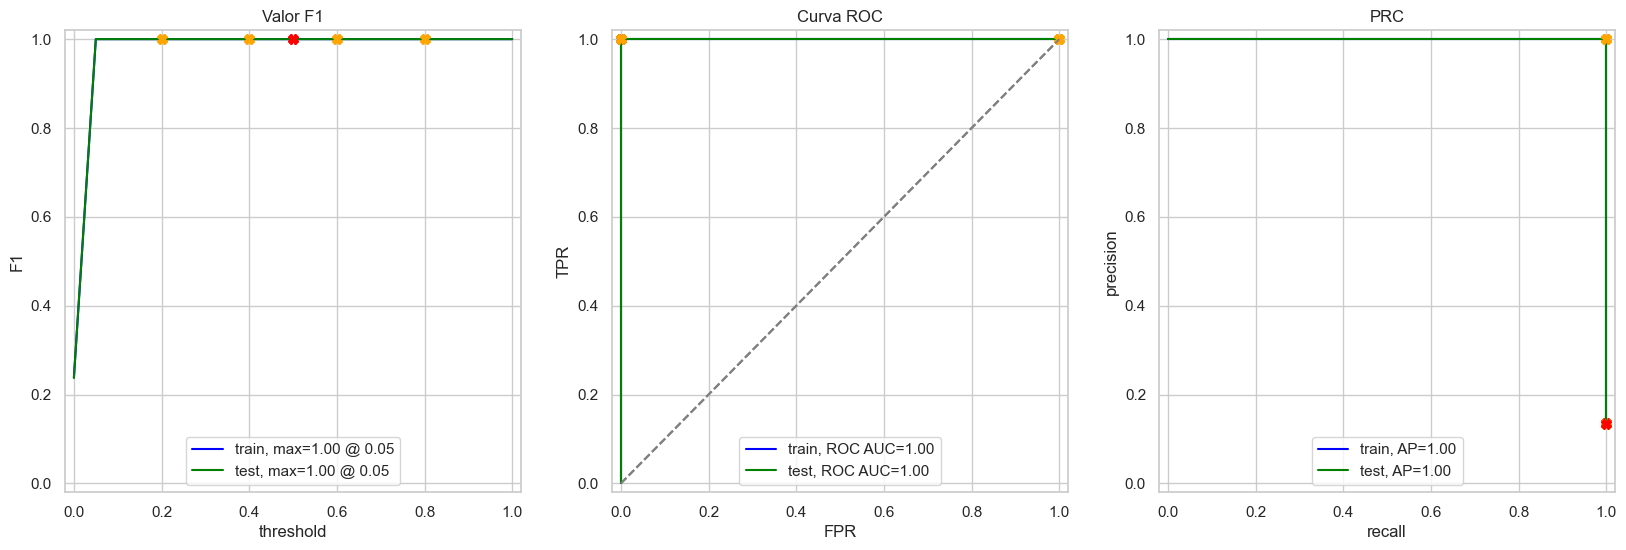

In [63]:
%time #llenar con los resultados anteriores
model_tree = DecisionTreeClassifier(random_state=12345, max_depth=10, criterion='gini')
model_tree.fit(features_train, target_train)
evaluate_model(model_tree, features_train, target_train, features_valid, target_valid)

In [75]:
accuracy_score_tree=1
auc_roc_tree=1

### Bosque aleatorio

In [64]:
model_forest = RandomForestClassifier()
param_grid = {
    'n_estimators':[20, 50, 100, 200],
    'criterion':['gini', 'entropy'],
    'max_depth':[10, 20, 30, 50],
    'class_weight':[None, 'balanced']
}
grid_forest = GridSearchCV(estimator=model_forest, param_grid=param_grid, scoring='roc_auc', cv=5, n_jobs=-1)
grid_forest.fit(features_train, target_train)
best_param_forest=grid_forest.best_params_


In [65]:
print(best_param_forest)
print(grid_forest.best_score_)

{'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'n_estimators': 20}
1.0


CPU times: total: 0 ns
Wall time: 0 ns
           train  test
Exactitud    1.0   1.0
F1           1.0   1.0
APS          1.0   1.0
ROC AUC      1.0   1.0


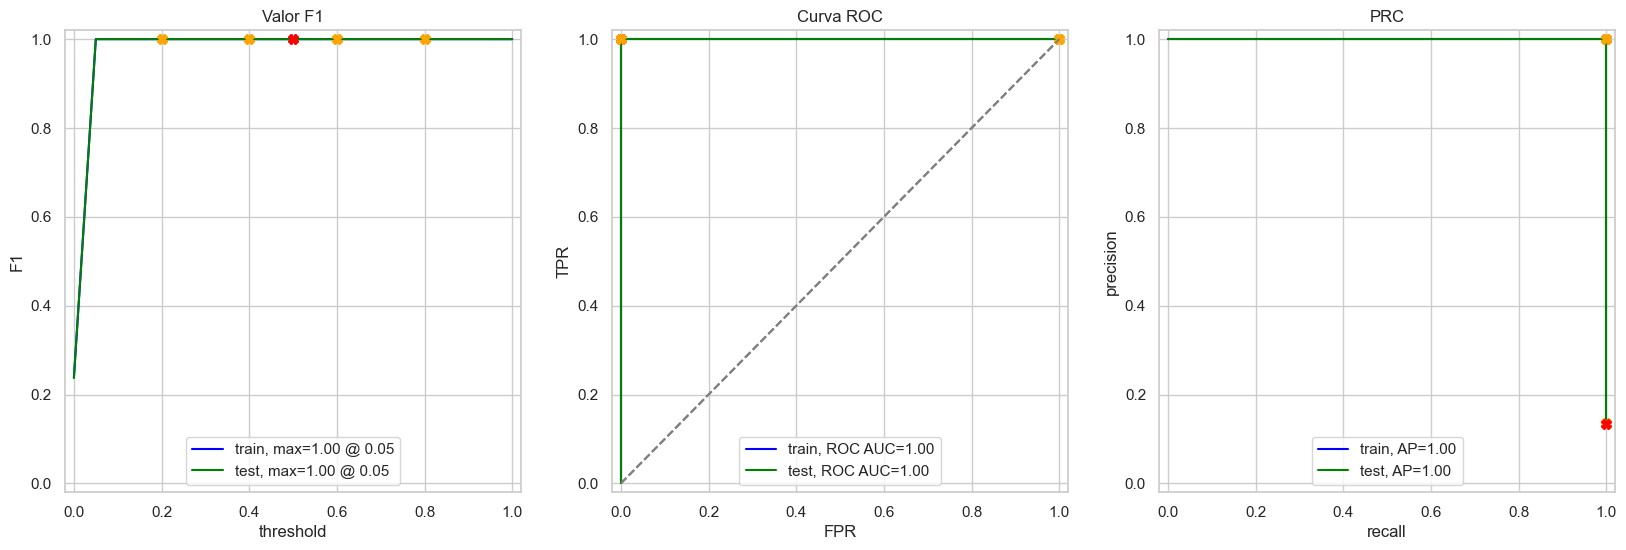

In [66]:
%time #llenar con los resultados anteriores
model_ba = RandomForestClassifier(random_state=12345, n_estimators=20,
                                  criterion='gini')
model_ba.fit(features_train, target_train)
evaluate_model(model_ba, features_train, target_train, features_valid, target_valid)

In [77]:
score_valid_ba=1
auc_roc_ba=1

### LightGBM


In [67]:
model_lgbm = LGBMClassifier()
param_grid = {
    'n_estimators':[20, 50, 100, 200, 300],
    'seed':[12345],
    'max_depth':[10, 20, 50],
    'learning_rate':[0.01, 0.05, 0.1]
}

grid_lgbm = GridSearchCV(estimator=model_lgbm, param_grid=param_grid, scoring='roc_auc', cv=5, n_jobs=-1)
grid_lgbm.fit(features_train, target_train)
best_param_lgbm=grid_lgbm.best_params_

[LightGBM] [Info] Number of positive: 43416, number of negative: 277867
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009530 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 557
[LightGBM] [Info] Number of data points in the train set: 321283, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.135133 -> initscore=-1.856315
[LightGBM] [Info] Start training from score -1.856315
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

In [68]:
print(best_param_lgbm)
print(grid_lgbm.best_score_)

{'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 20, 'seed': 12345}
0.9999999946121546


CPU times: total: 0 ns
Wall time: 0 ns
[LightGBM] [Info] Number of positive: 43416, number of negative: 277867
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012426 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 557
[LightGBM] [Info] Number of data points in the train set: 321283, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.135133 -> initscore=-1.856315
[LightGBM] [Info] Start training from score -1.856315
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warni

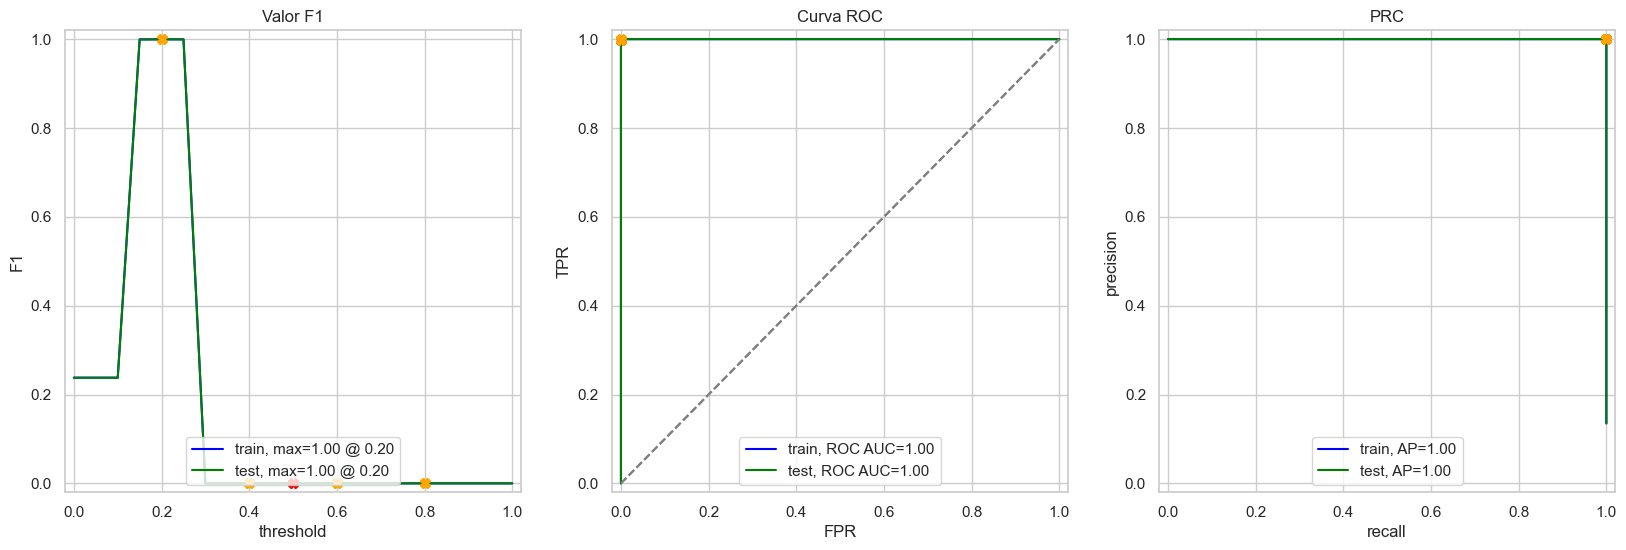

In [69]:
%time
model_lgbm = LGBMClassifier(n_estimators=20, seed=12345, max_depth=10, objective='binary', learning_rate=0.01)
model_lgbm.fit(features_train, target_train)
evaluate_model(model_lgbm, features_train, target_train, features_valid, target_valid)

In [79]:
acc_scor_lgbm=0.87
auc_roc_lgbm=1

### XGBoost

In [70]:
model_xgb = XGBClassifier(use_label_encoder=False, objective='binary:logistic', eval_metric='error')
param_grid = {
    'n_estimators':[20, 50],
    'max_depth':[10, 20, 50],
    'learning_rate':[0.01, 0.05, 0.1],
    'gamma':[0, 0.1, 0.2, 0.3, 0.4]
}

grid_xgb = GridSearchCV(estimator=model_xgb, param_grid=param_grid, scoring='roc_auc', cv=5, n_jobs=-1)

grid_xgb.fit(features_train, target_train)
best_param_xgb=grid_xgb.best_params_

c:\Users\ZonaDigital\Documents\3. Repositorios\Hackaton-Triple_ten-Team-8\venv\lib\site-packages\xgboost\core.py:158: UserWarning:

[14:25:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.




In [71]:
print(best_param_xgb)
print(-grid_xgb.best_score_)

{'gamma': 0, 'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 20}
-0.9999999788624013


CPU times: total: 0 ns
Wall time: 0 ns


c:\Users\ZonaDigital\Documents\3. Repositorios\Hackaton-Triple_ten-Team-8\venv\lib\site-packages\xgboost\core.py:158: UserWarning:

[14:26:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.




           train  test
Exactitud   0.86  0.87
F1          0.00  0.00
APS         1.00  1.00
ROC AUC     1.00  1.00


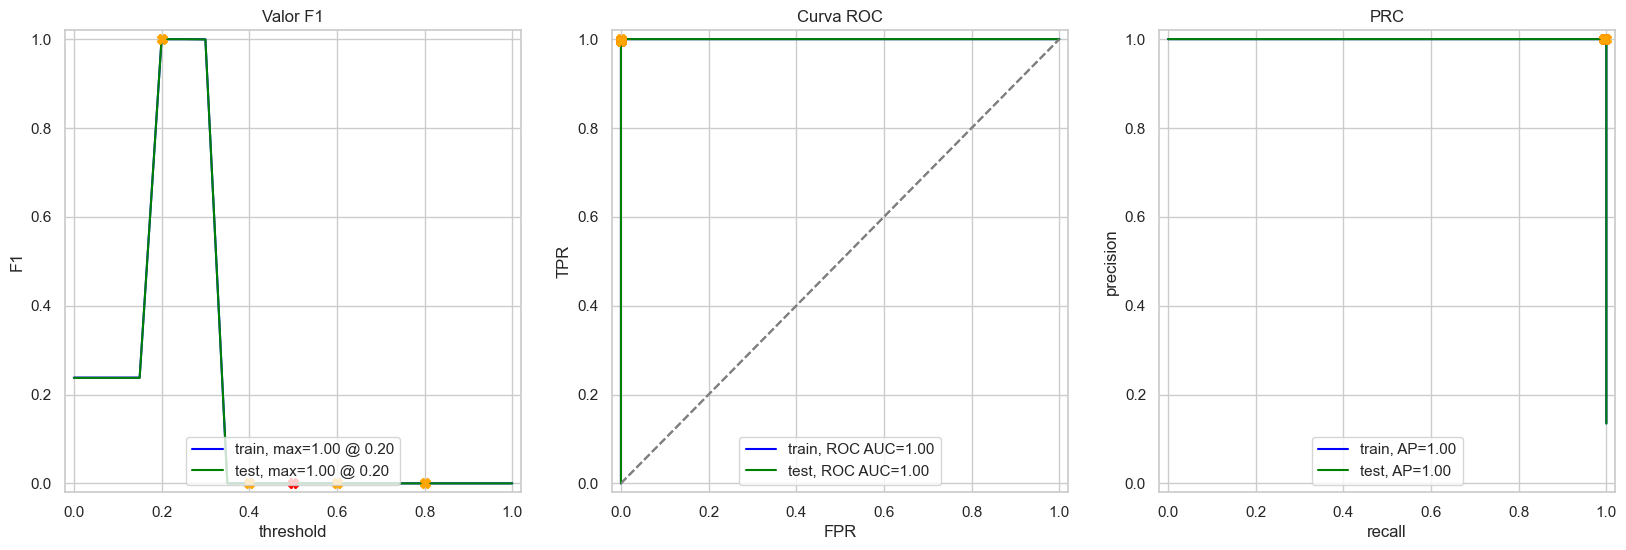

In [72]:
%time
model_xgb = XGBClassifier(use_label_encoder=False, objective='binary:logistic', eval_metric='error', 
                          n_estimators=20, seed=12345, max_depth=10 , gamma=0, learning_rate=0.01)
model_xgb.fit(features_train, target_train)
evaluate_model(model_xgb, features_train, target_train, features_valid, target_valid)

In [73]:
acc_xgb=0.87
auc_roc_xgb=1

## Model Evaluation

In [82]:
# Se realizará un cuadro resumen 

values = [
    ['Logistic Regression', score_valid, auc_roc_lr],
    ['Decision Tree C', accuracy_score_tree, auc_roc_tree],
    ['Random Forest C', score_valid_ba, auc_roc_ba], 
    ['LightGBM C', acc_scor_lgbm, auc_roc_lgbm],
    ['XGBoost C', acc_xgb, auc_roc_xgb]]

resumen_models = pd.DataFrame(values, columns=['Model', 'Exactitud', 'AUC-ROC'])
resumen_models = resumen_models.set_index('Model')
resumen_models.sort_values(by='AUC-ROC', ascending=False)

,Exactitud,AUC-ROC
Model,,
Decision Tree C,1.00,1.00
LightGBM C,0.87,1.00
Random Forest C,1.00,1.00
XGBoost C,0.87,1.00
Logistic Regression,0.95,0.97


## Conclusiones